In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from datetime import datetime
from dataclasses import dataclass, field
import glob
import os
import eigsep_observing as eo
import jax
import jax.numpy as jnp
import optax
from functools import partial
import matplotlib.dates as mdates
%matplotlib widget

## I measured the dimensions of my antenna

* l = 235 mm, one rod, middle piece is about 37 mm, so whole thing is about 507 mm, about .507 m
* d = 6 mm, so a = 3 mm = .003 m
* r = 97 m, from notes

In [2]:
waveform = np.load('/home/dominiv/eigsep/data/july2025/trans_spec/transmitter.npz')
print(waveform.keys())
bram = waveform['max_addr']
waveform = waveform['data']
trans_spec = np.fft.fft(waveform)

Vfwd_bit = np.max(waveform)
bit_range = 2**(13) # data is signed, so its 2^13 not 14
V_rfsoc = 2 # RFSoC's DAC range, +- volts peak-peak
output = (V_rfsoc) / (bit_range-1)
Vpeak = Vfwd_bit * output
Vfwd = Vpeak/np.sqrt(2) # Vrms conversion
print(Vfwd)

KeysView(NpzFile '/home/dominiv/eigsep/data/july2025/trans_spec/transmitter.npz' with keys: data, max_addr)
1.2728094715925353


In [100]:
path = '/home/dominiv/eigsep/data/july2025/corr_data/'
def file_finder(path, date, start, end):
    files = glob.glob(path+'corr_'+date+'_*')
    start_time = datetime.strptime(date+f'_{start}', '%Y%m%d_%H%M%S')
    end_time = datetime.strptime(date+f'_{end}', '%Y%m%d_%H%M%S')
    filtered_files = []
    for file in files:
        basename = os.path.basename(file)
        try:
            timestamp_str = basename[5:-3]  # Strip 'corr_' prefix and '.h5' suffix
            file_time = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
            if start_time <= file_time <= end_time:
                filtered_files.append(file)
        except ValueError:
            continue
    ordered_files = sorted(filtered_files)
    print('Number of files:', len(ordered_files))
    print(f'{str(ordered_files[0])}, {str(ordered_files[-1])}')
    return ordered_files

def header_check(picos, idx, header='imu_panda'):
    if f'{header}' not in picos.keys():
        print(f'{header} not found in file:', idx)

def data_extract(files):
    data_list = []
    corr_list = []
    pico_list = []
    for i in range(len(files)):
        data, corr, pico = eo.io.read_hdf5(files[i])
        header_check(pico, i)
        data_list.append(data)
        corr_list.append(corr)
        pico_list.append(pico)
    return data_list, corr_list, pico_list

def spectra(data, ant, corr):
    data_stack = [d[ant] for d in data]
    data_stack = np.array(data_stack)
    data_stack = np.concatenate(data_stack, axis=0)

    times = [d['times'] for d in corr]
    times = np.array(times)
    times = np.concatenate(times, axis=0)
    return data_stack, times

def waterfall(data, times, freqs, pos=False):
    dt = [datetime.fromtimestamp(ts) for ts in times]
    t_md = mdates.date2num(dt)
    plt.figure(figsize=(10,6))
    plt.imshow(np.log10(data), aspect = 'auto', interpolation='none', extent = [freqs[0], freqs[-1], t_md[-1], t_md[0]], 
               origin='upper', cmap='viridis')
    ax = plt.gca()
    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Time of Day')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plotter(freqs, spec, amount=[0,0]):
    plt.figure(figsize=(10,6))
    if spec.shape[:][0] > 1 and amount != [0,0]:
        for i in range(amount[0], amount[1]):
            plt.semilogy(freqs, spec[i], label=f'Spectra index: {i}')
    else:
        plt.semilogy(freqs, spec, label='Spectra')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.show()



def pico_info(picos, device, info):
    pico = [d[device] for d in picos]
    print(len(pico))
    print(type(pico))
    print(type(pico[0]))
    pl   = [entry[info] 
            for sublist in pico 
            for entry   in sublist]
    print(type(pl), len(pl))
    return np.array(pl)


sunday = file_finder(path, '20250720', '092000', '111200') # sunday from 9:58 pdt, battery swap at around 11:01 (12:01 in notes) (original was 9:58 to 12:13, is wrong)


data, corr, pico = data_extract(sunday)

data_stack, times = spectra(data, '2', corr) # use after friday for box data
print(data_stack.shape)

# data_stack = np.delete(data_stack, np.s_[-473:-351], axis=0) # getting rid of the data that corresponds to the time transmitter was off, 2 minutes ish

Number of files: 24
/home/dominiv/eigsep/data/july2025/corr_data/corr_20250720_092946.h5, /home/dominiv/eigsep/data/july2025/corr_data/corr_20250720_110841.h5
(5760, 1024)


In [15]:
@dataclass
class MotorSteps:
    az_range_deg : np.ndarray
    el_range_deg : np.ndarray
    el_first : bool
    start : dict[str, int] = field(default_factory=lambda: {"az": 0, "el": 0})  # start pos in steps
    up_delay_us : dict[str, int] = field(default_factory=lambda: {"az": 2400, "el": 2400})
    dn_delay_us : dict[str, int] = field(default_factory=lambda: {"az": 300, "el": 600})
    slowdown_factor : int = 2
    slow_zone : int = 100  # in steps
    step_angle_deg : float = 1.8
    microstep : int = 1
    gear_teeth : int = 113

    def __post_init__(self):
        self.extra_delay = {k: self.slowdown_factor * v for k, v in self.dn_delay_us.items()}

        if self.el_first:
            self.axis1 = "az"  # the slow axis
            self.axis2 = "el"  # fast axis / inner loop
            self.ax1_rng = az_range_deg.copy()
            self.ax2_rng = el_range_deg.copy()
        else:
            self.axis1 = "el"
            self.axis2 = "az"
            self.ax1_rng = el_range_deg.copy()
            self.ax2_rng = az_range_deg.copy()

    def steps2deg(self, steps):
        s = steps / self.microstep / self.gear_teeth
        deg = s * self.step_angle_deg
        return float(deg)
    
    def deg_to_steps(self, degrees):
        s = degrees / self.step_angle_deg
        return int(s * self.microstep * self.gear_teeth)

    @property
    def steps(self):
        """
        Calculate the list of steps taken.

        Returns
        -------
        s : list
            Each element is a tuple of (axis, number of steps).

        """
        # steps per position
        # inner: full range every time
        nsteps_inner = self.deg_to_steps(self.ax2_rng[-1] - self.ax2_rng[0])
        # outer: one position each time  (assumes here that each position has the same step increment -- an always valid assumption in our case)
        nsteps_outer = self.deg_to_steps(self.ax1_rng[1] - self.ax1_rng[0])
        # for each outer position, take nsteps_inner steps on inner axis and then nsteps_outer steps on outer axis to get to next outer pos
        s = [(self.axis1, nsteps_outer), (self.axis2, nsteps_inner)] * self.ax1_rng.size
        # first outer step is taken into account in separate stow calculation so remove it from here
        return s[1:]

    @property
    def positions(self):
        """
        Get the arrays of postions.

        Returns
        -------
        dict
            Key is axis name, value is array of positions.
        """
        a2, a1 = np.meshgrid(self.ax2_rng, self.ax1_rng)
        a1 = a1.ravel()
        a2[1::2] = a2[1::2, ::-1]  # reverse every a1 position
        a2 = a2.ravel()
        return {self.axis1: a1, self.axis2: a2}

    def stow_time(self):
        raise NotImplementedError

    def calc_time(self, include_stow=False):
        t = 0
        for ax, ns in self.steps:
            nslow = np.minimum(2*self.slow_zone, ns)  # number of slow steps
            t += ns * (self.dn_delay_us[ax] + self.up_delay_us[ax]) + nslow * self.extra_delay[ax]
        if include_stow:
            t += self.stow_time()
        return t / 1e6

In [16]:
az_range_deg = np.linspace(-180.0, 180.0, 72, endpoint=False)
el_range_deg = np.linspace(-180.0, 180.0, 72, endpoint=False)
ms = MotorSteps(az_range_deg, el_range_deg, el_first=True)

pos        = ms.positions
az_seq     = pos['az']       # (5184,)
el_seq     = pos['el']

# rename your "times" to "scan_times"
scan_times = np.zeros(len(az_seq), float)

def step_time(ax, n_steps):
    base  = ms.up_delay_us[ax] + ms.dn_delay_us[ax]
    slow  = min(2*ms.slow_zone, n_steps)
    extra = slow * ms.extra_delay[ax]
    return (n_steps*base + extra) / 1e6

# 2) loop over scan points (not over measurements!)
for i in range(len(az_seq)-1):
    da = abs(az_seq[i+1] - az_seq[i])
    de = abs(el_seq[i+1] - el_seq[i])
    sa = ms.deg_to_steps(da) if da>0 else 0
    se = ms.deg_to_steps(de) if de>0 else 0
    scan_times[i+1] = scan_times[i] + step_time('az', sa) + step_time('el', se)

# 3) prepare your measurement‐clock
t_unix      = np.array(times, dtype=float)   # (5760,)
t0          = t_unix[0]                     # or your known scan start
t_elapsed   = t_unix - t0                    # (5760,)  

# 4) interpolate az/el at each measurement time
az_aligned  = np.interp(t_elapsed, scan_times, az_seq,
                        left=az_seq[0], right=az_seq[-1])
el_aligned  = np.interp(t_elapsed, scan_times, el_seq,
                        left=el_seq[0], right=el_seq[-1])

# 5) bundle (all length 5760)
data1       = np.array(data_stack)                # (5760,1024)
aligned = {
    't_unix':   t_unix,       # original Unix times
    't_elapsed':t_elapsed,    # seconds since t0
    'az':       az_aligned,   # (5760,)
    'el':       el_aligned,   # (5760,)
    'data1':    data1,        # (5760,1024)
}

In [42]:
5760-(473-351)

5638

(5760,) (5760,) (5760, 1024)
(5568,) (5568,) (5568, 1024)


/tmp/ipykernel_181597/3177312521.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


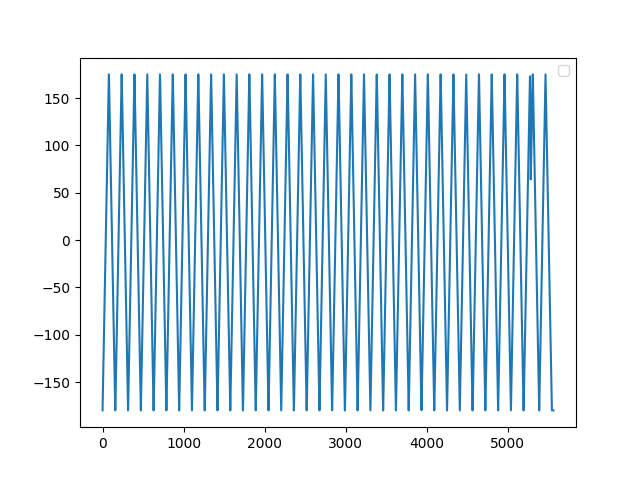

In [101]:
dac_off_start = 5287
dac_off_end = 5409
cutoff_point = 5690
print(aligned['az'].shape, aligned['el'].shape, data_stack.shape)


big_az = aligned['az'][:cutoff_point]
big_el = aligned['el'][:cutoff_point]
data_stack = data_stack[:][:cutoff_point]
big_az = np.delete(big_az, np.s_[dac_off_start:dac_off_end], axis=0)
big_el = np.delete(big_el, np.s_[dac_off_start:dac_off_end], axis=0)
data_stack = np.delete(data_stack, np.s_[dac_off_start:dac_off_end], axis=0) # getting rid of the data that corresponds to the time transmitter was off, 2 minutes ish

print(big_az.shape, big_el.shape, data_stack.shape)

plt.figure()
# plt.plot(aligned['t_unix'])
# plt.plot(aligned['t_unix'], aligned['el'], label = 'el')
# plt.plot(aligned['t_unix'], aligned['az'], label = 'az')
plt.plot(big_el)
plt.legend()
plt.show()

In [7]:
class Beam_finder:
    def __init__(self, a=.002, r=1, l=.33):
        self.a = a
        self.r = r
        self.l = l
        self.c = 3e8
        self.Vfwd = 1.2728094715925353

    def T11(self, theta, phi):
        return ((jnp.cos(theta)) * (jnp.cos(phi)))**2
    
    def T12(self, theta, phi):
        return -jnp.cos(theta) * jnp.cos(phi) * jnp.sin(phi)
    
    def T22(self, phi):
        return jnp.sin(phi)**2
    
    def T_mat(self, theta, phi):
        t11 = self.T11(theta, phi)
        t12 = self.T12(theta, phi)
        t21 = self.T12(theta, phi)
        t22 = self.T22(phi)
        mat = jnp.array([[t11, t12], [t21, t22]])
        return mat
    
    def Zin(self, freq):
        Rrad = 20 * jnp.pi**2 * ((freq * self.l) / self.c)**2
        X = (-120 / jnp.pi) * (self.l * freq / self.c) * (jnp.log(self.l / (2 * self.a)) -1)
        return Rrad + 1j*X
    
    def Prad(self, freq):
        z0 = 50 # ohms, most cables have 50 ohm impedence
        z = self.Zin(freq)
        tau = (z - z0) / (z + z0)
        eff = 1 - jnp.abs(tau)**2
        eta = .9 # antenna made of aluminum, so Rloss is approx 0, so eta is approx 1
        # return Pav * eff * eta # Pav is our T matrix? dont really need?
        Pfwd = (jnp.abs(self.Vfwd)**2) / z0
        Pin = eff * Pfwd
        return Pin * eta
    
    def vis_(self, freq, theta, phi, A):
        P = self.Prad(freq)
        t_mat = self.T_mat(theta, phi) * P
        A_conj = jnp.conj(A).T
        con_mult = jnp.dot(t_mat, A_conj)
        v = jnp.dot(A, con_mult)
        return jnp.array(v)[0][0]

    def loss(self, A, freq, theta, phi, V):
        model = self.vis_(freq, theta, phi, A)
        res = jnp.mean((model - V)**2)
        return res
    
    @partial(jax.jit, static_argnums=(0,))
    def update(self, A, opt_state, freq, theta, phi, V):
        g = jax.grad(self.loss)(A, freq, theta, phi, V)
        updates, opt_state = opt.update(g, opt_state)
        return optax.apply_updates(A, updates), opt_state
   
    def A_mag(self, A):
        return np.linalg.norm(A)
    
    def T_mag(self, freq, T):
        P = self.Prad(freq)
        return np.linalg.norm(T * P)

    def save_beam(self, freq, A, idx, perc):
        np.savez(self.path + f'beam_at_{freq:.0f}MHz', As = A, err_idx = idx, err_perc = perc)
   
    def find_beam(self, freq, theta, phi, A_init, V, learning_rate=10, iteration=10000):
        loss_grad = jax.jit(jax.grad(self.loss))
        opt = optax.adam(learning_rate)
        opt_state = opt.init(A_init)
        A = A_init
        
        for i,frequency in enumerate(freq):
            As = []
            err_idx = []
            err_perc = []
            for j in range(len(theta)):
                for _ in range(iteration):
                    A, opt_state = self.update(A, opt_state, frequency, theta[j], phi[j], V[i][j])
                mag = self.A_mag(A)
                A_vis = self.vis_(frequency, theta[j], phi[j], A)
                percent_diff = (A_vis - V[i][j]) / V[i][j] * 100
                if jnp.abs(percent_diff) >= 5:
                    err_idx.append(j)
                    err_perc.append(percent_diff)
            As = np.array(As)
            err_idx = np.array(err_idx)
            err_perc = np.array(err_perc)
            self.save_beam(frequency, As, err_idx, err_perc)
            print(f'Saved beam at {frequency} MHz')

In [58]:
## goes hard!

class Beam_finder:
    def __init__(self, a: float = 0.002, r: float = 1.0, l: float = 0.33, path='./'):
        self.a = a
        self.r = r
        self.l = l
        self.c = 3e8
        self.Vfwd = 1.2728094715925353
        self.path = path
        os.makedirs(self.path, exist_ok=True)

    def T11(self, theta, phi):
        return (jnp.cos(theta) * jnp.cos(phi))**2

    def T12(self, theta, phi):
        return -jnp.cos(theta) * jnp.cos(phi) * jnp.sin(phi)

    def T22(self, phi):
        return jnp.sin(phi)**2

    def T_mat(self, theta, phi):
        t11 = self.T11(theta, phi)
        t12 = self.T12(theta, phi)
        t21 = t12
        t22 = self.T22(phi)
        return jnp.array([[t11, t12],
                          [t21, t22]])

    def Zin(self, freq):
        Rrad = 20 * jnp.pi**2 * ((freq * self.l) / self.c)**2
        X = (-120 / jnp.pi) * (self.l * freq / self.c) * (jnp.log(self.l / (2 * self.a)) - 1)
        return Rrad + 1j * X

    def Prad(self, freq):
        z0 = 50.0
        z = self.Zin(freq)
        tau = (z - z0) / (z + z0)
        eff = 1 - jnp.abs(tau)**2
        eta = 0.9
        Pfwd = (jnp.abs(self.Vfwd)**2) / z0
        return eff * Pfwd * eta

    def vis_(self, freq, theta, phi, A):
        P = self.Prad(freq)
        t_mat = self.T_mat(theta, phi) * P
        A_conj = jnp.conj(A).T
        result = (A @ (t_mat @ A_conj))[0, 0]
        return result

    def loss(self, A, freq, theta, phi, V):
        pred = self.vis_(freq, theta, phi, A)
        return jnp.mean((pred - V)**2)

    @partial(jax.jit, static_argnames=('self','optimizer'))
    def update(self, A, opt_state, freq, theta, phi, V, optimizer):
        grads = jax.grad(self.loss)(A, freq, theta, phi, V)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_A = optax.apply_updates(A, updates)
        return new_A, new_opt_state

    def save_beam(self, freq, A_host, err_idx, err_perc):
        """A_host, err_idx, err_perc should be plain NumPy arrays."""
        fn = os.path.join(self.path, f'beam_{freq:.0f}MHz.npz')
        np.savez(fn, A=A_host, err_idx=err_idx, err_perc=err_perc)
        print(f"saved: {fn}")

    def find_beam(self,
                  freqs, 
                  thetas,
                  phis,  
                  A_init,
                  V,     
                  learning_rate=10.0,
                  iterations=10000):

        optimizer = optax.adam(learning_rate)

        for i, freq in enumerate(freqs):
            A = A_init
            opt_state = optimizer.init(A)

            As = []
            err_idx = []
            err_perc = []
            for j, (θ, ϕ) in enumerate(zip(thetas, phis)):
                print(j)
                V_meas = V[j, i]
                for _ in range(iterations):
                    A, opt_state = self.update(
                        A, opt_state,
                        freq, θ, ϕ, V_meas,
                        optimizer
                    )
                As.append(A)
                A_vis = self.vis_(freq, θ, ϕ, A)
                pdiff = (A_vis - V_meas) / V_meas * 100
                if jnp.abs(pdiff) >= 5:
                    err_idx.append(j)
                    err_perc.append(pdiff)

            As_host      = jax.device_get(jnp.stack(As))
            err_idx_host = np.array(jax.device_get(jnp.array(err_idx)))
            err_perc_host= np.array(jax.device_get(jnp.array(err_perc)))

            self.save_beam(freq, As_host, err_idx_host, err_perc_host)

        return As_host

In [8]:
class Beam_finder:
    def __init__(self, a: float = 0.002, r: float = 1.0, l: float = 0.33, path='./'):
        self.a = a
        self.r = r
        self.l = l
        self.c = 3e8
        self.Vfwd = 1.2728094715925353
        self.path = path
        os.makedirs(self.path, exist_ok=True)

    def T11(self, theta, phi):
        return (jnp.cos(theta) * jnp.cos(phi))**2

    def T12(self, theta, phi):
        return -jnp.cos(theta) * jnp.cos(phi) * jnp.sin(phi)

    def T22(self, phi):
        return jnp.sin(phi)**2

    def T_mat(self, theta, phi):
        t11 = self.T11(theta, phi)
        t12 = self.T12(theta, phi)
        t21 = t12
        t22 = self.T22(phi)
        return jnp.array([[t11, t12],
                          [t21, t22]])

    def Zin(self, freq):
        Rrad = 20 * jnp.pi**2 * ((freq * self.l) / self.c)**2
        X = (-120 / jnp.pi) * (self.l * freq / self.c) * (jnp.log(self.l / (2 * self.a)) - 1)
        return Rrad + 1j * X

    def Prad(self, freq):
        z0 = 50.0
        z = self.Zin(freq)
        tau = (z - z0) / (z + z0)
        eff = 1 - jnp.abs(tau)**2
        eta = 0.9
        Pfwd = (jnp.abs(self.Vfwd)**2) / z0
        return eff * Pfwd * eta

    def vis_(self, freq, theta, phi, A):
        P = self.Prad(freq)
        t_mat = self.T_mat(theta, phi) * P
        A_conj = jnp.conj(A).T
        result = (A @ (t_mat @ A_conj))[0, 0]
        return result

    def loss(self, A, freq, theta, phi, V):
        pred = self.vis_(freq, theta, phi, A)
        return jnp.mean((pred - V)**2)

    @partial(jax.jit, static_argnames=('self','optimizer'))
    def update(self, A, opt_state, freq, theta, phi, V, optimizer):
        grads = jax.grad(self.loss)(A, freq, theta, phi, V)
        updates, new_opt_state = optimizer.update(grads, opt_state)
        new_A = optax.apply_updates(A, updates)
        return new_A, new_opt_state

    def save_beam(self, freq, A_host, err_idx, err_perc):
        """A_host, err_idx, err_perc should be plain NumPy arrays."""
        fn = os.path.join(self.path, f'beam_{freq:.0f}MHz.npz')
        np.savez(fn, A=A_host, err_idx=err_idx, err_perc=err_perc)
        print(f"saved: {fn}")

    def find_beam(self,
                  freqs, 
                  thetas,
                  phis,  
                  A_init,
                  V,     
                  learning_rate=10.0,
                  iterations=10000,
                  max_retries=5):
    
        optimizer = optax.adam(learning_rate)
    
        for i, freq in enumerate(freqs):
            print(f"=== Frequency {freq/1e6:.1f} MHz ===")
            As, err_idx, err_perc = [], [], []
    
            for j, (θ, ϕ) in enumerate(zip(thetas, phis)):
                print(j)
                V_meas = V[j, i]
    
                # start each measurement with a fresh A & state
                A        = A_init
                opt_state = optimizer.init(A)
                pdiff     = None
    
                # try up to `max_retries` times
                for attempt in range(1, max_retries+1):
                    # run your usual gradient loop
                    for _ in range(iterations):
                        A, opt_state = self.update(
                            A, opt_state,
                            freq, θ, ϕ, V_meas,
                            optimizer
                        )
    
                    # compute percent-difference
                    A_vis = self.vis_(freq, θ, ϕ, A)
                    pdiff = (A_vis - V_meas) / V_meas * 100
    
                    if jnp.abs(pdiff) < 5:
                        # success! stop retrying
                        break
                    else:
                        print(f"  meas {j}: retry {attempt}, pdiff={pdiff:.1f}%")
                        # OPTION A: restart from the original A_init
                        A        = A_init
                        opt_state = optimizer.init(A)
                        # OPTION B (instead): comment out the above two lines
                        # so you continue refining from the last A/state
    
                # store final A and any errors
                As.append(A)
                if jnp.abs(pdiff) >= 5:
                    err_idx.append(j)
                    err_perc.append(pdiff)
    
            # checkpoint this frequency
            As_host      = jax.device_get(jnp.stack(As))
            err_idx_host = np.array(jax.device_get(jnp.array(err_idx)))
            err_perc_host= np.array(jax.device_get(jnp.array(err_perc)))
            self.save_beam(freq, As_host, err_idx_host, err_perc_host)

    # def solve_A_direct(self, freq, theta, phi, V_meas):
    #     """
    #     Closed-form solve for A given one (freq,theta,phi,V_meas):
    #       M = Prad(freq) * T_mat(theta,phi)      # 2×2 Hermitian
    #       M = U @ diag([λ1,λ2]) @ U^H            # via eigh
    #       choose A = sqrt(V_meas/λ1) * u1
    #     Returns A with shape (1,2).
    #     """
    #     # 1) Build M = P * T
    #     P = self.Prad(freq)               # scalar
    #     T = self.T_mat(theta, phi)        # 2×2 matrix
    #     M = P * T                          # still 2×2 Hermitian

    #     # 2) Eigen-decompose M
    #     # `eigh` returns eigenvalues in ascending order
    #     eigenvals, eigenvecs = jnp.linalg.eigh(M)
    #     # principal eigenpair:
    #     λ1 = eigenvals[-1]                # largest eigenvalue
    #     u1 = eigenvecs[:, -1]             # corresponding unit-length eigenvector

    #     # 3) Scale u1 so that A M A^H == V_meas
    #     #    ⇒ (α u1) M (α u1)^H = α^2 λ1 = V_meas
    #     alpha = jnp.sqrt(V_meas / λ1)
    #     A_direct = alpha * u1             # shape (2,)

    #     # 4) Return as row-vector (1×2) for compatibility
    #     return A_direct[jnp.newaxis, :]

    # def find_beam_direct(self, freqs, thetas, phis, V):
    #     """
    #     Loop over all freqs×angles, apply solve_A_direct, and stack results:
    #       output shape = (n_freq, n_meas, 2)
    #     """
    #     allA = []
    #     for i, freq in enumerate(freqs):
    #         freqAs = []
    #         for j, (θ, ϕ) in enumerate(zip(thetas, phis)):
    #             V_meas = V[j, i]
    #             Aij = self.solve_A_direct(freq, θ, ϕ, V_meas)
    #             freqAs.append(Aij)   # each is (1,2)
    #         # stack per-frequency: (n_meas,2)
    #         allA.append(jnp.vstack(freqAs))
    #     # final: (n_freq, n_meas, 2)
    #     return jnp.stack(allA)

            
    def solve_A_direct(self, freq, θ, ϕ, V_meas):
        P = self.Prad(freq)
        T = self.T_mat(θ, ϕ)
        M = P * T

        λs, U = jnp.linalg.eigh(M)

        λ_max = λs[-1]
        u_max = U[:, -1]

        scale = jnp.sqrt(V_meas / λ_max)
        A_direct = scale * u_max

        return A_direct[jnp.newaxis, :]

    def find_beam_direct(self, freqs, thetas, phis, V):
        allA = []
        for i, f in enumerate(freqs):
            freqA = []
            for j, (θ, ϕ) in enumerate(zip(thetas, phis)):
                Aj = self.solve_A_direct(f, θ, ϕ, V[j, i])
                freqA.append(Aj)
            allA.append(jnp.vstack(freqA))
        return jnp.stack(allA)   

In [103]:
finder = Beam_finder(a=.003, r=97, l=.507)
# allA = finder.find_beam_direct(all_my_freqs, big_el, big_az, all_my_vis)
allA = finder.find_beam_direct(all_my_freqs, jnp.deg2rad(big_el), jnp.deg2rad(big_az), all_my_vis) # start with radians, works best, no log needed to get beam shape

In [102]:
data_stack[:,::16][:,0].shape
all_my_freqs = jnp.array(corr[0]['freqs'][::16]) * 1e6
all_my_vis = jnp.array(data_stack[:, ::16])
print(first_freq)
print((big_el.shape), (big_az.shape), (all_my_vis.shape))
print(all_my_freqs[40:41], all_my_vis[:,13:].shape) #52 is 203MHz

[      0. 3906250.]
(5568,) (5568,) (5568, 64) (2,)
[1.5625e+08] (5568, 51)


In [104]:
np.savez('/home/dominiv/eigsep/my_notebooks/july2025/all_freq_rad_dacoff.npz', As = allA)

In [107]:
def beam_map(A, theta, phi, freq, nside=16, fwhm=45, iterations=100, logscale=True, rot=(0,0,0)):
    if type(A[0]) != np.float64:
        A = np.squeeze(A, axis=1)
        A_mags = np.linalg.norm(A, axis=1)
        print(A_mags.shape)
    else:
        A_mags = A
        
    npix = hp.nside2npix(nside)
    
    m = np.full(npix, hp.UNSEEN)
    theta = np.mod(theta, 2*np.pi)
    new_theta = np.where(theta > np.pi, 2*np.pi - theta, theta)
    
    new_phi = np.mod(phi, 2*np.pi)
    pix = hp.ang2pix(nside, new_theta, new_phi)
    print("min:", A_mags.min(), "max:", A_mags.max())
    print("number of zeros:", np.count_nonzero(A_mags == 0))
    print("number of non-positive:", np.count_nonzero(A_mags <= 0))
    floor = 1e-20
    if logscale:
        for p, v in zip(pix, A_mags):
            # m[p] = np.log10(v)
            m[p] = v
            # m[p] = np.log10(max(v, floor))
        m_smooth= hp.smoothing(m, fwhm=np.radians(fwhm), iter=iterations)
        m_smooth = np.where(m_smooth>0, np.log10(m_smooth), hp.UNSEEN)
        # m_smooth = np.log10(m_smooth)
    else:
        for p, v in zip(pix, A_mags):
            m[p] = v
        m_smooth= hp.smoothing(m, fwhm=np.radians(fwhm), iter=iterations)
            
    
    # m_smooth= hp.smoothing(m, fwhm=np.radians(fwhm), iter=iterations)
    
    neighbours = hp.get_all_neighbours(nside, np.arange(npix))
    mask = m_smooth == hp.UNSEEN
    for pixl in np.where(mask)[0]:
        nbrs = neighbours[:, pixl]
        valid = nbrs[nbrs>=0]
        vals = m_smooth[valid]
        vals = vals[vals!=hp.UNSEEN]
        if vals.size:
            m_smooth[pixl] = vals.mean()
    hp.mollview(m_smooth, rot=rot, title=f'Beam at {freq/1e6:.3f} MHz, log={logscale}')
    plt.show()
    return m_smooth

rad_theta = np.deg2rad(big_el)
rad_phi = np.deg2rad(big_az)


(126,) (99,)
(5690,)
min: 4532.312 max: 574805.06
number of zeros: 0
number of non-positive: 0


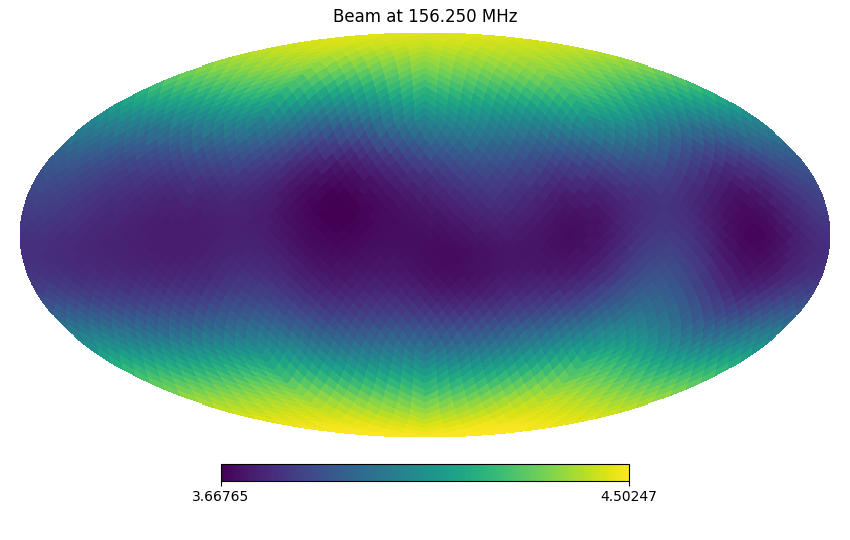

In [250]:
s156 = np.load('/home/dominiv/eigsep/my_notebooks/july2025/beam_156250000MHz.npz')
s156_old = np.load('/home/dominiv/eigsep/my_notebooks/july2025/sunday_156MHz_A_map_update.npz')
s70 = np.load('/home/dominiv/eigsep/my_notebooks/july2025/beam_242187500MHz.npz')

s70_A = s70['A']
s156_A = s156['A']
s156_old_A = s156_old['As']

s156_perc = s156['err_perc']
s156_old_perc = s156_old['err_perc']

print(s156_old_perc.shape, s156_perc.shape)
# smooth_map70 = beam_map(s70_A, rad_theta, rad_phi, all_my_freqs[-2])
smooth_map156 = beam_map(s156_A, rad_theta, rad_phi, all_my_freqs[40], logscale=True)
# smooth_map156_old = beam_map(s156_old_A, rad_theta, rad_phi, all_my_freqs[40], logscale=False)

In [105]:
allA_data_rad = np.load('./all_freq_single_test_rad.npz')['As']
allA_data_single = np.load('./all_freq_single_test.npz')['As']
allA_data = np.load('./all_freq.npz')['As']
allA_data_allrad = np.load('./all_freq_rad.npz')['As']
allA_data_rad_dacoff = np.load('./all_freq_rad_dacoff.npz')['As']

(5690,)
min: 0.0 max: 421321.2
number of zeros: 8
number of non-positive: 8


/tmp/ipykernel_181597/102801071.py:27: RuntimeWarning: invalid value encountered in log10
  m_smooth = np.where(m_smooth>0, np.log10(m_smooth), hp.UNSEEN)


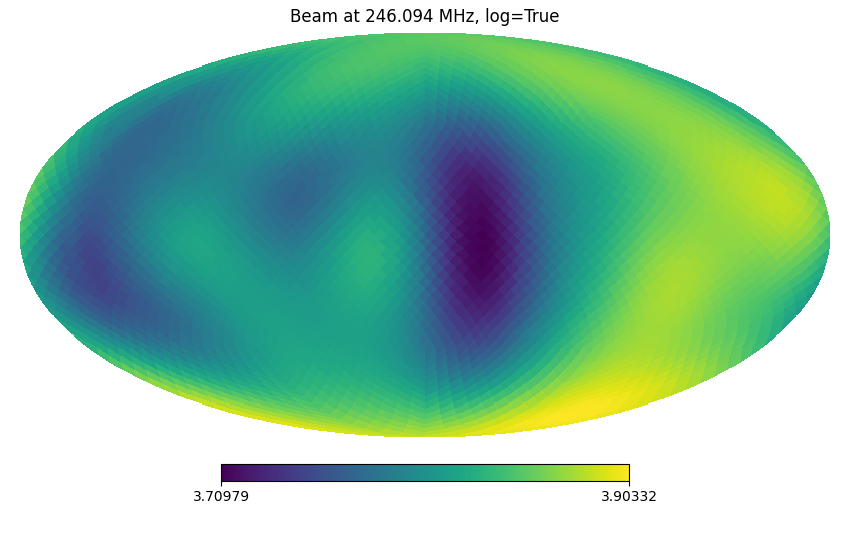

(5690,)
min: 0.0 max: 446088.2
number of zeros: 8
number of non-positive: 8


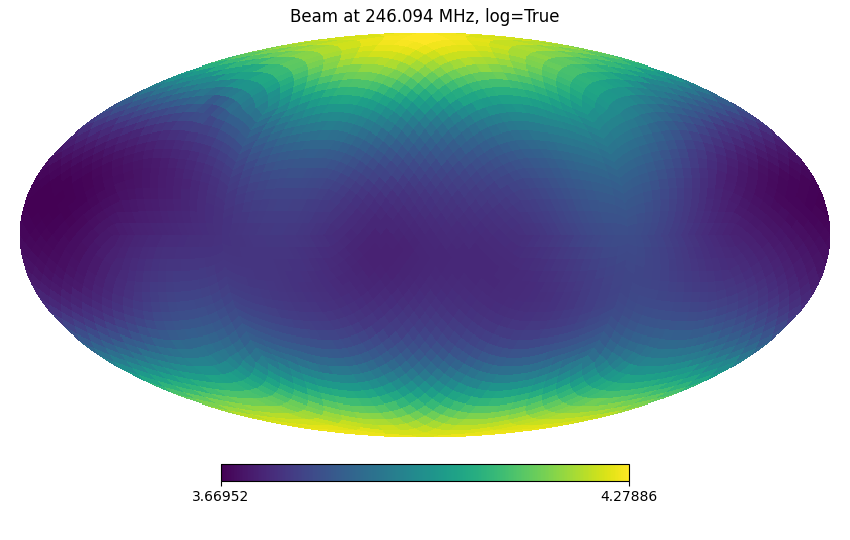

(5690,)
min: 0.0 max: 421321.2
number of zeros: 8
number of non-positive: 8


/home/dominiv/venv/jupyter/lib/python3.12/site-packages/healpy/visufunc.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = pylab.figure(fig, figsize=(8.5, 5.4))


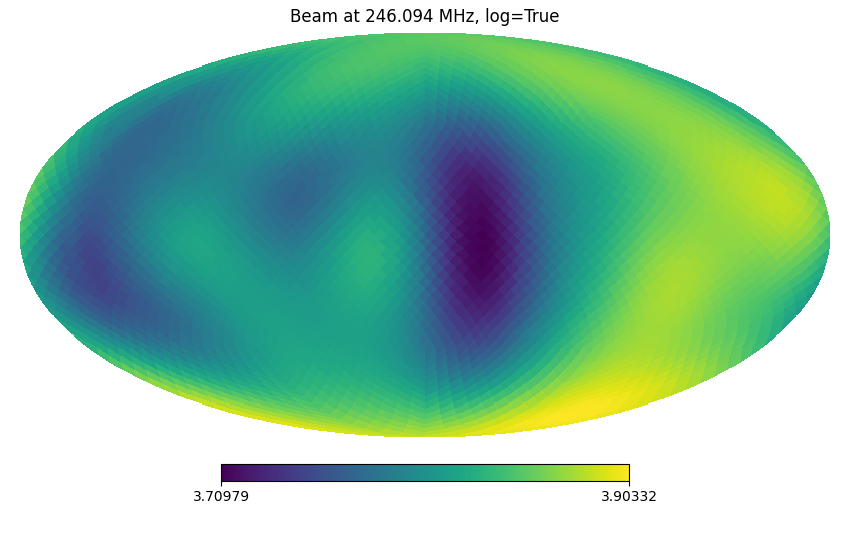

(5690,)
min: 0.0 max: 446088.2
number of zeros: 8
number of non-positive: 8


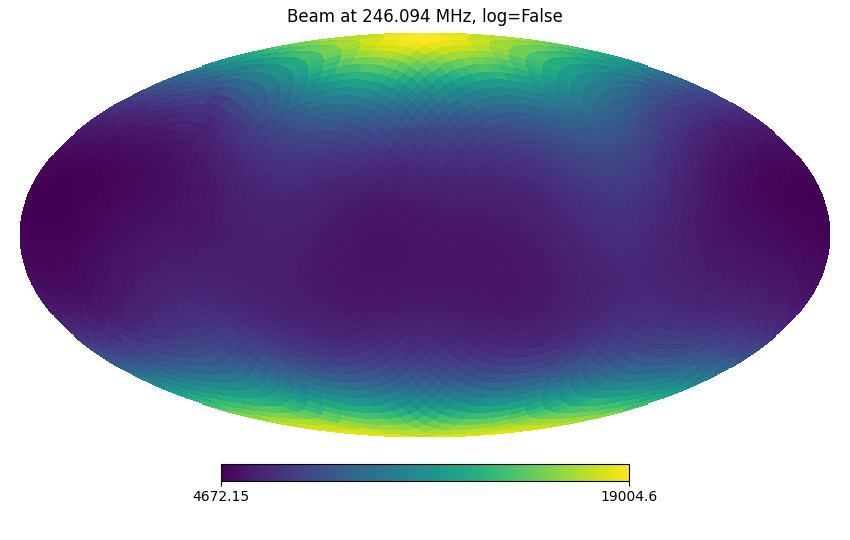

In [127]:
checking = -1

smooth_map_allA = beam_map(allA_data[checking][:,None,:], rad_theta, rad_phi, all_my_freqs[checking], logscale=True, rot=(0,0,0))
smooth_map_allA_rad = beam_map(allA_data_allrad[checking][:,None,:], rad_theta, rad_phi, all_my_freqs[checking], logscale=True, rot=(-90,0,90))
smooth_map_allA_single = beam_map(allA_data_single[checking][:,None,:], rad_theta, rad_phi, all_my_freqs[checking], logscale=True, rot=(0,0,0))
smooth_map_allA_single_rad = beam_map(allA_data_rad[checking][:,None,:], rad_theta, rad_phi, all_my_freqs[checking], logscale=False, rot=(-90,0,90))

(5690,)
min: 0.0 max: 446088.2
number of zeros: 8
number of non-positive: 8


/tmp/ipykernel_181597/102801071.py:27: RuntimeWarning: invalid value encountered in log10
  m_smooth = np.where(m_smooth>0, np.log10(m_smooth), hp.UNSEEN)


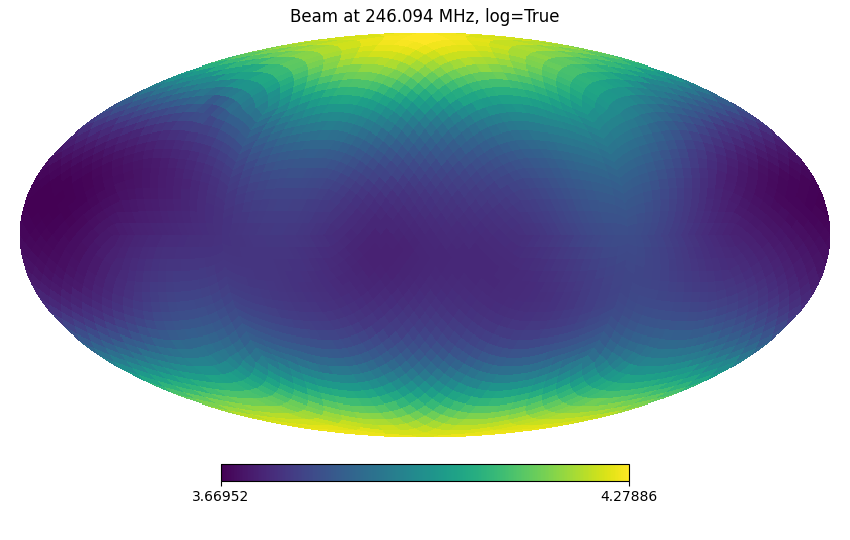

(5568,)
min: 0.0 max: 446088.2
number of zeros: 8
number of non-positive: 8


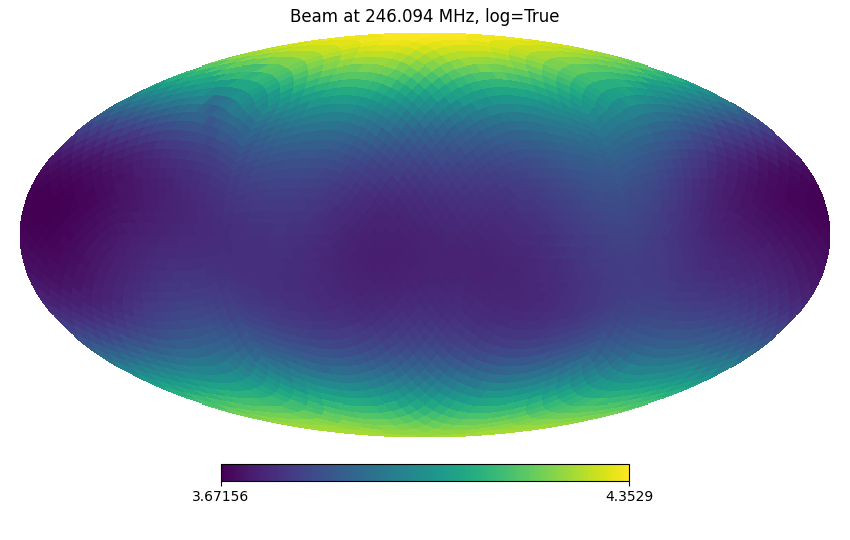

In [130]:
smooth_map_allA_rad = beam_map(allA_data_allrad[checking][:,None,:], rad_theta, rad_phi, all_my_freqs[checking], nside=16, logscale=True, rot=(-90,0,90))
smooth_map_allA_rad_dacoff = beam_map(allA_data_rad_dacoff[checking][:,None,:], rad_theta, rad_phi, all_my_freqs[checking], nside=16, logscale=True, rot=(-90,0,90))

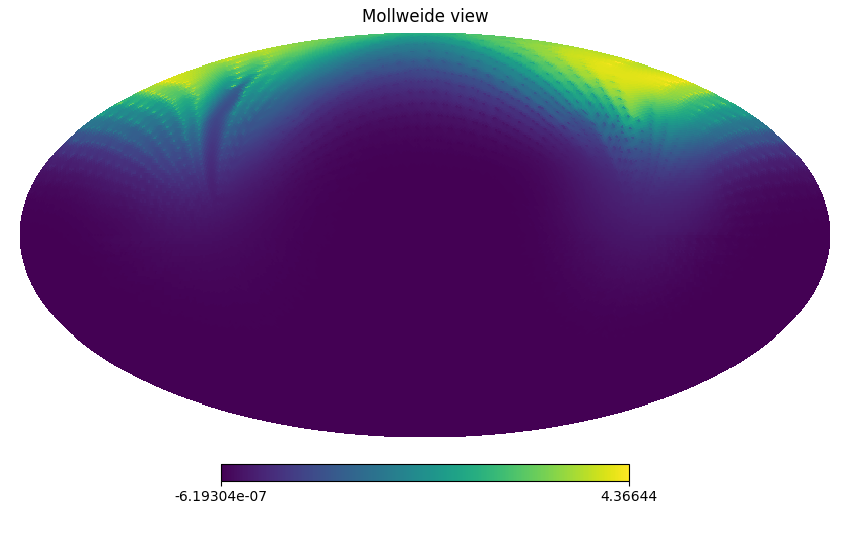

In [129]:
hp.mollview(((smooth_map_allA_rad_dacoff - smooth_map_allA_rad) / smooth_map_allA_rad) * 100, rot=(-90,0,90))

In [115]:
plt.close('all')

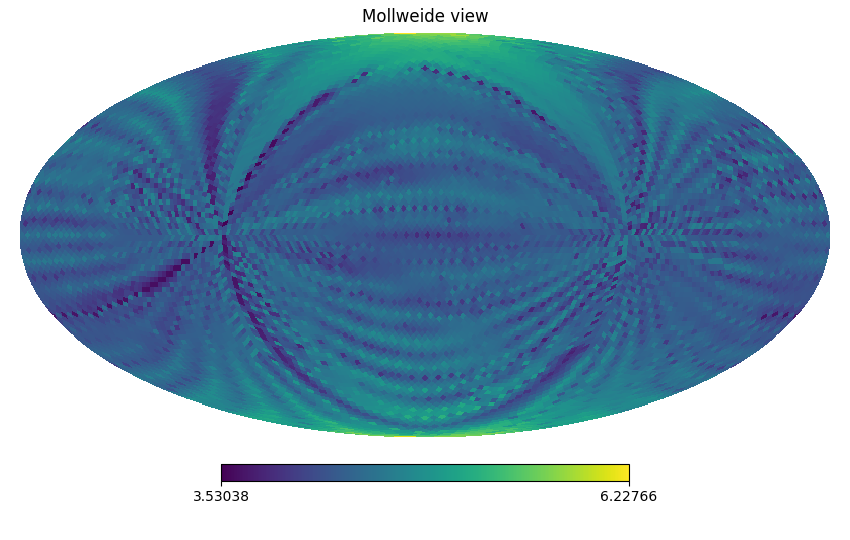

In [21]:
def log_morphological_fill(m_linear, nside, fwhm=None, max_iters=500):
    """
    Fill UNSEEN holes in log‐space *without* ever flooring.

    Parameters
    ----------
    m_linear : array
        Healpix map in linear space, with holes marked by hp.UNSEEN.
    nside : int
        Healpix nside.
    fwhm : float or None
        If given, pre‐smooth linear map by this many degrees.
    max_iters : int
        Maximum number of full‐sky passes to do.  Usually O(diameter) passes suffice.

    Returns
    -------
    m_log : array
        Log10‐map with holes filled by iterative neighbor‐averaging.
    """
    # 1) (optional) smooth linear first
    if fwhm is not None:
        m_work = hp.smoothing(m_linear, fwhm=np.radians(fwhm),
                              verbose=False)
    else:
        m_work = m_linear.copy()

    npix = hp.nside2npix(nside)
    # 2) build masked log‐map
    m_log = np.full(npix, hp.UNSEEN)
    good = (m_work > 0)
    m_log[good] = np.log10(m_work[good])

    # 3) adjacency once
    nbrs = hp.get_all_neighbours(nside, np.arange(npix))

    # 4) iterate: pull in only *existing* log‐values
    mask = (m_log == hp.UNSEEN)
    for it in range(max_iters):
        changed = False
        # find current holes
        holes = np.where(mask)[0]
        if holes.size == 0:
            break
        for p in holes:
            # collect valid neighbor log‐values
            nb = nbrs[:, p]
            nb = nb[nb >= 0]
            vals = m_log[nb]
            vals = vals[vals != hp.UNSEEN]
            if vals.size:
                m_log[p] = vals.mean()
                mask[p] = False
                changed = True
        if not changed:
            # no more fillable holes reachable by propagation
            break

    return m_log


A = np.squeeze(allA_data_allrad[checking][:,None,:], axis=1)
A_mags = np.linalg.norm(A, axis=1)


nside = 32 # used 16
npix  = hp.nside2npix(nside)

m156= np.full(npix, hp.UNSEEN)
theta_mod = np.mod(np.deg2rad(big_el), 2*np.pi)
new_theta = np.where(theta_mod > np.pi,
                 2*np.pi - theta_mod,
                 theta_mod)

new_phi = np.mod(np.deg2rad(big_az), 2*np.pi)
pix = hp.ang2pix(nside, new_theta, new_phi)

for p, v in zip(pix, A_mags):
    # m156[p] = np.log10(v)
    m156[p] = (v)

m_log = log_morphological_fill(m156, nside=nside, fwhm=None)

hp.mollview(m_log, rot=(-90,0,90))

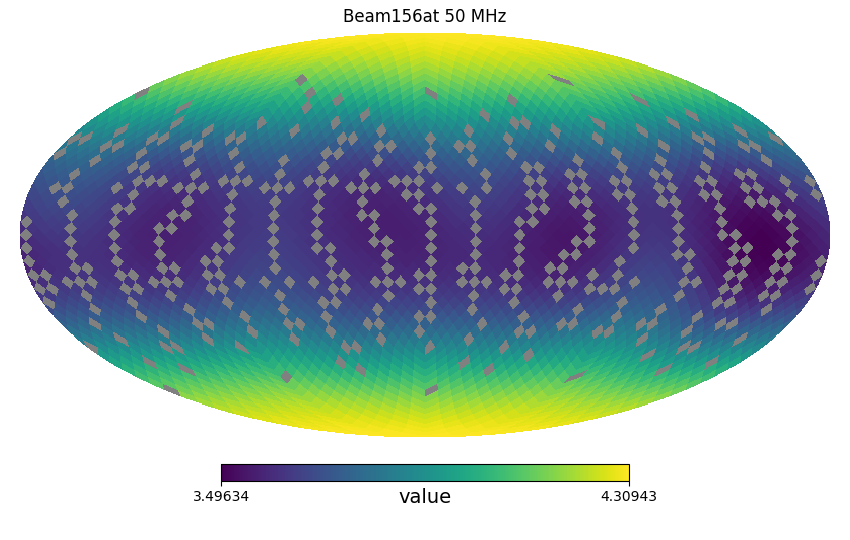

In [110]:
# s156_A = np.squeeze(s156_A, axis=1)

A_mags = np.linalg.norm(allA[0], axis=1)
nside = 16 # used 16
npix  = hp.nside2npix(nside)

m156= np.full(npix, hp.UNSEEN)
theta_mod = np.mod(np.deg2rad(big_el), 2*np.pi)
new_theta = np.where(theta_mod > np.pi,
                 2*np.pi - theta_mod,
                 theta_mod)

new_phi = np.mod(np.deg2rad(big_az), 2*np.pi)
pix = hp.ang2pix(nside, new_theta, new_phi)

for p, v in zip(pix, A_mags):
    m156[p] = np.log10(v)
    # m[p] = (v)

m_smooth156 = hp.smoothing(
    m156,
    fwhm=np.radians(45),  
    iter=100,                
) # used fwhm=np.radians(45) and iter=100


# — plot it —
hp.mollview(
    m_smooth156,
    title=f"Beam156at {50} MHz",
    unit="value",
    # rot=(0,90,0)
    # min=0,
    # max=A_mags.max()
)
# hp.graticule()
plt.show()

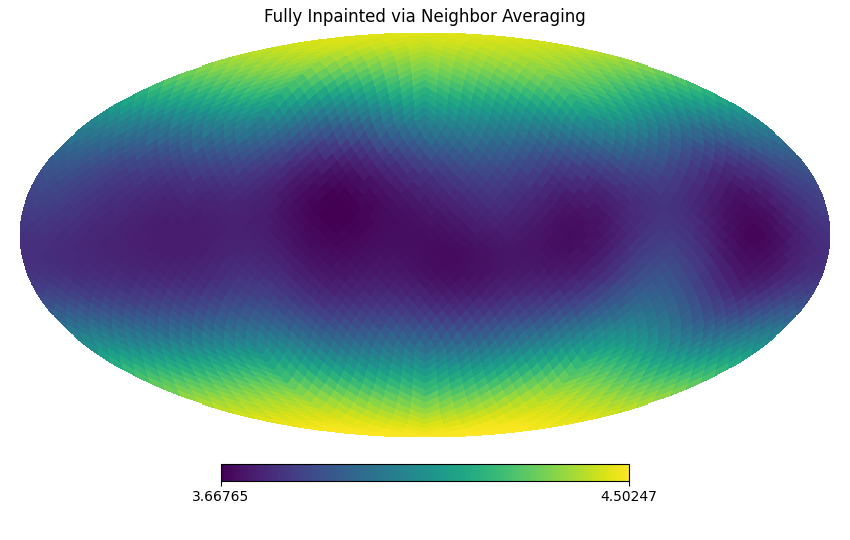

In [60]:

neighbors = hp.get_all_neighbours(nside, np.arange(npix))  # shape (8, npix)
m_nn156 = m_smooth156.copy()

for _ in range(1):  # do up to 10 sweeps
    mask = m_nn156 == hp.UNSEEN
    if not np.any(mask):
        break
    for pix in np.where(mask)[0]:
        nbrs = neighbors[:, pix]
        # discard out-of-range neighbours (==-1) and UNSEEN
        valid = nbrs[nbrs>=0]
        vals  = m_nn156[valid]
        vals  = vals[vals!=hp.UNSEEN]
        if vals.size:
            m_nn156[pix] = vals.mean()

hp.mollview(m_nn156, title="Fully Inpainted via Neighbor Averaging")
# hp.graticule()
plt.show()

In [71]:
data_stack.shape[0]-473 + 122-10
# 473-351

5399

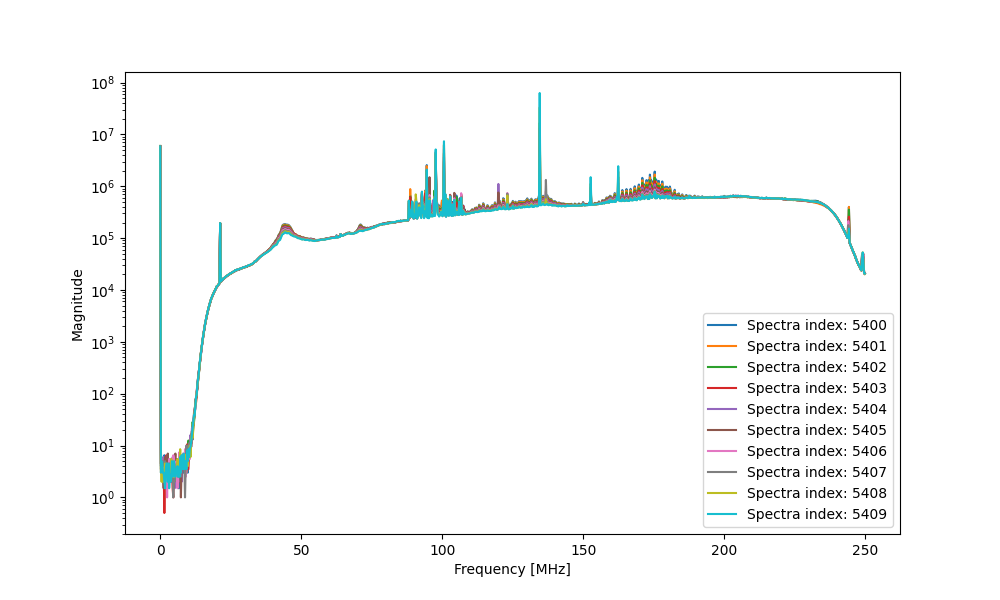

In [83]:
# limits = 360+122 # -473 to -351 dac is off
limits = 5400 # 5287 to 5409 dac is off
data_cutoff = data_stack[:][:cutoff_point]
# plotter(corr[0]['freqs'], data_cutoff, amount=[-limits, -limits + 10])
plotter(corr[0]['freqs'], data_cutoff, amount=[limits, limits + 10])

In [87]:
plt.close('all')

In [94]:
print(data_cutoff.shape, data_stack.shape)
print(data_stack.shape[0] - cutoff_point)

(5690, 1024) (5760, 1024)
70


(5568, 1024)


/tmp/ipykernel_181597/2035071735.py:51: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(data), aspect = 'auto', interpolation='none', extent = [freqs[0], freqs[-1], t_md[-1], t_md[0]],
/tmp/ipykernel_181597/2035071735.py:51: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data), aspect = 'auto', interpolation='none', extent = [freqs[0], freqs[-1], t_md[-1], t_md[0]],


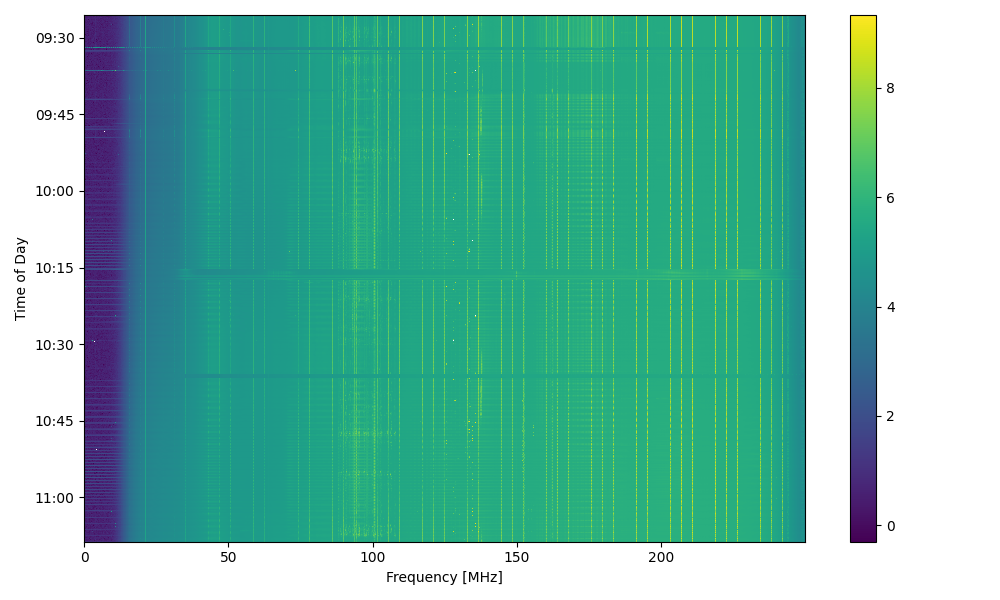

In [99]:
test_stack = np.delete(data_cutoff, np.s_[5287:5409], axis=0)
print(test_stack.shape)

waterfall(test_stack, times, corr[0]['freqs'])